In [18]:
#importing required modules

from pathlib import Path
from tempfile import NamedTemporaryFile
import fileinput
import os
import rdkit
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import gensim
import matplotlib.pyplot as plt
import gensim.downloader
from rdkit.Chem import Descriptors
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, LeaveOneOut, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C, RationalQuadratic, Matern
import numpy as np
import itertools
import random
import scipy
import pickle

In [19]:
'''
Three functions that assist in converting lists to strings and vice versa.
These are helpful when storing vectors in csv files. 
'''

def str2float(string):
    split = list(string.split(','))
    floats_split = []
    for i in range(len(split)):
        floats = float(split[i])
        floats_split.append(floats)
    return floats_split

def stringToList(vectors):
    bracket_removed_mol2vec = []
    for i in range(len(vectors)):
        new_strings = vectors[i].replace('[', '')
        newer_strings = new_strings.replace(']', '')
        bracket_removed_mol2vec.append(newer_strings)

# Convert all vectors
    xList = []
    for i in range(len(bracket_removed_mol2vec)):
        float_vec = str2float(bracket_removed_mol2vec[i])
        xList.append(float_vec)
    
    return xList

def listToString(vectors):
    string_indices = []
    for i in range(len(vectors)):
        knn_string = ', '.join(str(k) for k in vectors[i])
        string_indices.append(knn_string)

    bracket_string_indices = []
    for i in range(len(string_indices)):
        bracket_string = '[' + string_indices[i] + ']'
        bracket_string_indices.append(bracket_string)
    
    return bracket_string_indices

In [20]:
def get_bootstrap_samples(data, n_samples, replace: bool = True, noise_scale: float = 0.5, seed = 228):
    """
    Wrapper function to bootstrap column densities in a dataset.
    The idea here is to generate "new" data by sampling with
    replacement, and adding Gaussian noise to the log column
    densities. The scale of the noise is set by the parameter
    `noise_scale`.
    Parameters
    ----------
    data : Tuple[np.ndarray]
        2-tuple containing X (2D) and y (1D) NumPy arrays
    seed : int
        Seed used to set the random state
    n_samples : int, optional
        Target dataset size, by default 500
    replace : bool, optional
        Whether to do bootstrapping with replacement, by default True
    noise_scale : float, optional
        Gaussian scale for target noise, by default 0.5
    Returns
    -------
    2-tuple
        boot_X is a 2D NumPy array of features with
        shape [N, L] where N = `n_samples`. boot_y
        is a NumPy 1D array with bootstrapped, noisy
        regression targets with shape [N].
    """
    boot_X, boot_y = resample(*data, n_samples=n_samples, replace=replace, random_state=seed)
    rng = np.random.default_rng(seed)
    boot_y += rng.normal(0., noise_scale, size=boot_y.size)
    return boot_X, boot_y

In [21]:
def getIsoSplits():
    '''
    This function splits the data 80:20 into train and test sets.
    
    
    The main isotopologues are first split 80:20 and then the minor isotopologues are assigned
    to the same set (train or test) as the parent species.
    
    The data is then bootstrapped with Gaussian noise and scaled.
    
    Returns:
    X_train_scaled: Scaled and bootstrapped feature vectors in training set.
    y_train_boot: Bootstrapped column densities in training set.
    X_test_scaled: Scaled and bootstrapped feature vectors in test set
    y_test_boot: Bootstrapped column densities in test set
    X_train_beforeBoot: Scaled feature vectors in training set (not bootstrapped)
    y_train: column densities in trainig set (not bootstrapped)
    X_test_beforeBoot: Scaled feature vectors in test set (not bootstrapped)
    y_test: Column densities in testing set (not bootstrapped)
    X_tot_scaled: Scaled feature vectors in combined train and test set
    y_tot: column densities in combined train and test set
    '''
    
    fullPath = os.path.join(os.getcwd(), 'final_detections.csv')
    full = pd.read_csv(fullPath)
    smiles = list(full['smiles'])
    y = list(np.log10(np.array(list(full['N']))))
    x = stringToList(list(full['final vectors iso 70']))
    parent = list(full['parent 2'])
    
    parentSmiles = []
    parentY = []
    parentX = []
    
    isoSmiles = []
    isoY = []
    isoX = []
    isoParents = []
    
    for i in range(len(parent)):
        if parent[i] == "Main":
            parentSmiles.append(smiles[i])
            parentY.append(y[i])
            parentX.append(x[i])
            
        else:
            isoSmiles.append(smiles[i])
            isoY.append(y[i])
            isoX.append(x[i])
            isoParents.append(parent[i])
            
            
    idxList = list(range(len(parentSmiles)))
    trainIdx, testIdx = train_test_split(idxList, train_size = 0.8, test_size = 0.2, random_state=0)
    
    X_train = [parentX[i] for i in trainIdx]
    y_train = [parentY[i] for i in trainIdx]
    smiles_train = [parentSmiles[i] for i in trainIdx]
    
    
    
    X_test = [parentX[i] for i in testIdx]
    y_test = [parentY[i] for i in testIdx]
    smiles_test = [parentSmiles[i] for i in testIdx]
    smiles_train_main = [parentSmiles[i] for i in trainIdx]
    smiles_test_main = [parentSmiles[i] for i in testIdx]
    
    for i in range(len(isoParents)):
        if isoParents[i] in smiles_train_main:
            X_train.append(isoX[i])
            y_train.append(isoY[i])
            smiles_train.append(isoSmiles[i])
            
        if isoParents[i] in smiles_test_main:
            X_test.append(isoX[i])
            y_test.append(isoY[i])
            smiles_test.append(isoSmiles[i])
            

    X_tot = np.array(X_train + X_test)
    y_tot = np.array(y_train + y_test)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    bootSize = 800
    totalLength = len(X_tot)
    bootTrainSize = round(bootSize*len(X_train)/totalLength)
    bootTestSize = round(bootSize*len(X_test)/totalLength)

    
    
    X_train_boot, y_train_boot = get_bootstrap_samples((X_train, y_train), n_samples = bootTrainSize)
    X_test_boot, y_test_boot = get_bootstrap_samples((X_test, y_test), n_samples = bootTestSize)

    
    scaler = preprocessing.StandardScaler().fit(X_train_boot)
    X_train_scaled = scaler.transform(X_train_boot)
    X_test_scaled = scaler.transform(X_test_boot)
    X_train_beforeBoot = scaler.transform(X_train)
    X_test_beforeBoot = scaler.transform(X_test)
    X_tot_scaled = scaler.transform(X_tot)
    
    return X_train_scaled, y_train_boot, X_test_scaled, y_test_boot, X_train_beforeBoot, y_train, X_test_beforeBoot, y_test, X_tot_scaled, y_tot
         
            

In [22]:
'''
Function that trains a Bayesian ridge regression model on the training data and evaluates it on the 
testing and training data. The evaluation metrics (MSE and R^2) are returned. 
'''

def runPredictionsBR(model, X_train_scaled, y_train_boot, X_test_scaled, y_test_boot, X_train, y_train, X_test, y_test, X_tot_scaled, y_tot):
    
    
    result = model.fit(X_train_scaled, y_train_boot)
    
    train_pred = result.predict(X_train_scaled)
    train_error = mean_squared_error(y_train_boot, train_pred)
    test_pred = result.predict(X_test_scaled)
    test_error = mean_squared_error(y_test_boot, test_pred)
    detectedPred = result.predict(X_tot_scaled)

    testPredFinal, testSD = result.predict(X_test, return_std=True)
    trainPredFinal, trainSD = result.predict(X_train, return_std=True)

    
    testMSE = mean_squared_error(testPredFinal, y_test)
    
    detectedMSE = mean_squared_error(y_tot,detectedPred)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_tot, detectedPred)
    detectedR2 = r_value**2

    
    return y_train, trainPredFinal, y_test, testPredFinal, detectedMSE, detectedR2, testSD, trainSD, testMSE

In [23]:
'''
Function that trains a Gaussian process regression model on the training data and evaluates it on the 
testing and training data. The evaluation metrics (MSE and R^2) are returned. 
'''

def runPredictionsGPR(model, X_train_scaled, y_train_boot, X_test_scaled, y_test_boot, X_train, y_train, X_test, y_test, X_tot_scaled, y_tot):
        
    result = model.fit(X_train_scaled, y_train_boot)

    train_pred = result.predict(X_train_scaled)
    train_error = mean_squared_error(y_train_boot, train_pred)
    test_pred = result.predict(X_test_scaled)
    test_error = mean_squared_error(y_test_boot, test_pred)
    detectedPred = result.predict(X_tot_scaled)
    
    testPredFinal, testSD = result.predict(X_test, return_std=True)
    trainPredFinal, trainSD = result.predict(X_train, return_std=True)
    
    testMSE = mean_squared_error(testPredFinal, y_test)
    
    detectedMSE = mean_squared_error(y_tot,detectedPred)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_tot, detectedPred)
    detectedR2 = r_value**2

    
    return y_train, trainPredFinal, y_test, testPredFinal, detectedMSE, detectedR2, testSD, trainSD, testMSE

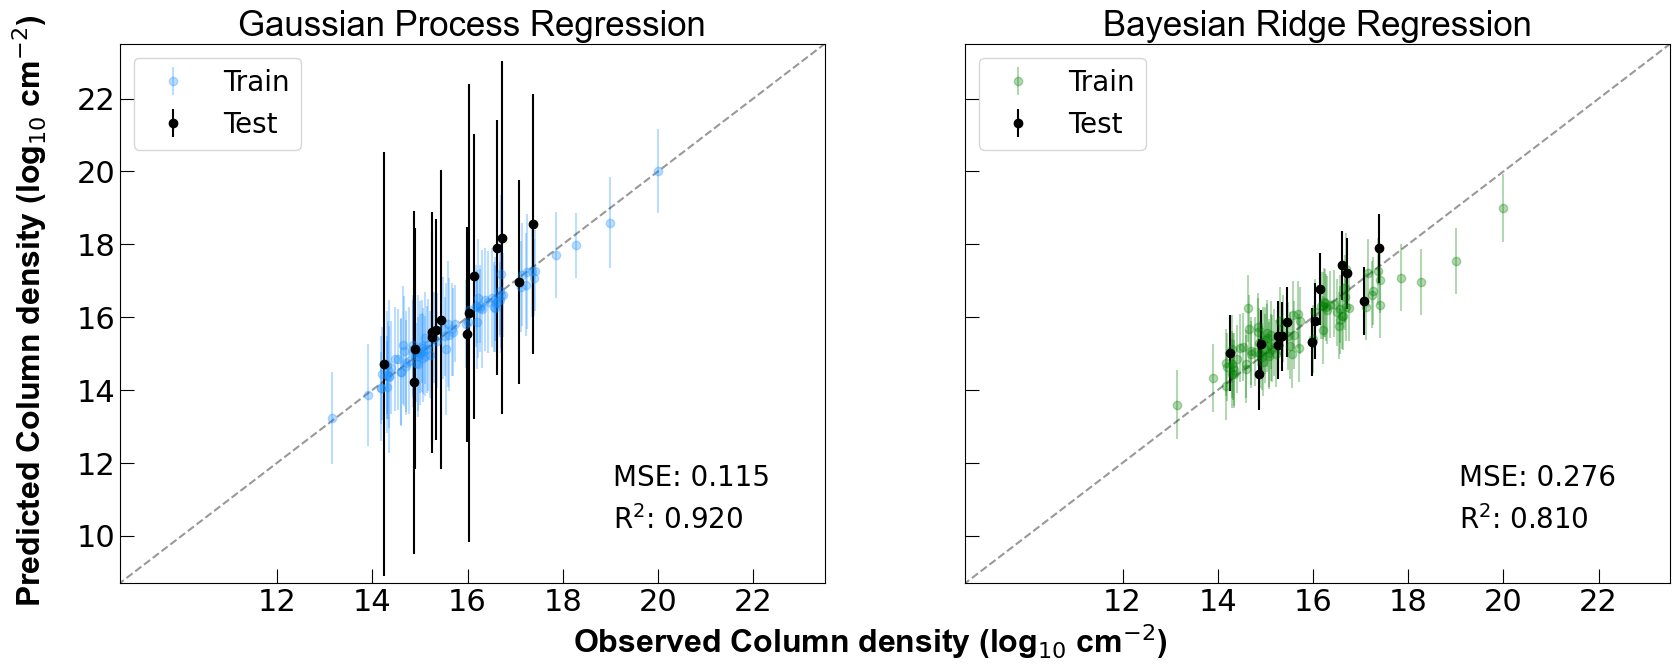

In [24]:
'''
This code cell calls runPredictionsGPR and runPredictionsBR functions in order to 
return the training and testing performance on the dataset. This information is then plotted. The resulting plot
is shown as Figure 2 in the paper. 

'''


hfont = {'fontname':'Arial'}

labelFont = 20
titleFont = 25

GPR_paramSet = (0.1, 10, 10, 0.1, 0, 10)

BR_paramSet = (1e-10, 1e-06, 1e-10, 100, 100, 0.1)


kernel = WhiteKernel(GPR_paramSet[3], noise_level_bounds = (1e-30, 1e30))+ RationalQuadratic(alpha = GPR_paramSet[1], length_scale = GPR_paramSet[0], length_scale_bounds = (1e-30, 1e30), alpha_bounds = (1e-30, 1e30)) + DotProduct(sigma_0=GPR_paramSet[2], sigma_0_bounds = (1e-30, 1e30)) 
GPR_model = GaussianProcessRegressor(kernel = kernel, normalize_y = True, n_restarts_optimizer = GPR_paramSet[4], alpha = GPR_paramSet[5])

BR_model = BayesianRidge(alpha_init = BR_paramSet[0], lambda_init = BR_paramSet[1], alpha_1 = BR_paramSet[2], alpha_2 = BR_paramSet[3], lambda_1 = BR_paramSet[4], lambda_2 = BR_paramSet[5])    


X_train_scaled, y_train_boot, X_test_scaled, y_test_boot, X_train, y_train, X_test, y_test, X_tot_scaled, y_tot = getIsoSplits()
GPR_y_train, GPR_train_pred, GPR_y_test, GPR_test_pred, mse_GPR, r2_GPR, GPR_testSD, GPR_trainSD, GPR_testMSE = runPredictionsGPR(GPR_model, X_train_scaled, y_train_boot, X_test_scaled, y_test_boot, X_train, y_train, X_test, y_test, X_tot_scaled, y_tot)
BR_y_train, BR_train_pred, BR_y_test, BR_test_pred, mse_BR, r2_BR, BR_testSD, BR_trainSD, BR_testMSE = runPredictionsBR(BR_model, X_train_scaled, y_train_boot, X_test_scaled, y_test_boot, X_train, y_train, X_test, y_test, X_tot_scaled, y_tot)

fig, axes =  plt.subplots(1, 2, figsize=(20,7), sharey = True)


#Plot Gaussian Process Regression scatterplots
axes[0].errorbar(GPR_y_train, GPR_train_pred, yerr = GPR_trainSD, fmt="o", c='dodgerblue', label='Train', alpha = 0.3)
axes[0].errorbar(GPR_y_test, GPR_test_pred, yerr = GPR_testSD, fmt="o", c='#010101', label='Test')
axes[0].set_title('Gaussian Process Regression', **hfont, fontsize = titleFont)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].set_xlim(8.7,23.5)
axes[0].set_ylim(8.7,23.5)
axes[0].set_xticks([12, 14, 16, 18, 20, 22])
axes[0].plot(np.arange(5,30), np.arange(5, 30), ls="--", alpha=0.4, color="k")
axes[0].text(0.7, 0.18, f"MSE: {mse_GPR:.3f}", transform=axes[0].transAxes, fontsize = labelFont)
axes[0].text(0.7, 0.1, f"R$^2$: {r2_GPR:.3f}", transform=axes[0].transAxes, fontsize = labelFont)
axes[0].legend(fontsize = 20)
axes[0].tick_params(axis="x", direction="in", labelsize=22, length=10, labeltop = False)
axes[0].tick_params(axis="y", direction="in", labelsize=22, length=10, labeltop = False)


# Plot Bayesian Ridge Regression scatterplots
axes[1].errorbar(BR_y_train, BR_train_pred, yerr = BR_trainSD, fmt="o", c='green', label='Train', alpha = 0.3)
axes[1].errorbar(BR_y_test, BR_test_pred, yerr = BR_testSD, fmt="o", c='#010101', label='Test')
axes[1].set_title('Bayesian Ridge Regression', **hfont, fontsize = titleFont)
axes[1].plot(np.arange(5,30), np.arange(5, 30), ls="--", alpha=0.4, color="k")
#13.7, 20
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].set_xlim(8.7,23.5)
axes[1].set_ylim(8.7,23.5)
axes[1].set_xticks([12, 14, 16, 18, 20, 22])
axes[1].text(0.7, 0.18, f"MSE: {mse_BR:.3f}", transform=axes[1].transAxes, fontsize = labelFont)
axes[1].text(0.7, 0.1, f"R$^2$: {r2_BR:.3f}", transform=axes[1].transAxes, fontsize = labelFont)
axes[1].legend(fontsize = 20)
axes[1].tick_params(axis="x", direction="in", labelsize=22, length=10, labeltop = False)
axes[1].tick_params(axis="y", direction="in", labelsize=22, length=10, labeltop = False)


fig.text(0.5, 0.01, 'Observed Column density (log$_{10}$ cm$^{-2}$)', ha='center', **hfont, fontsize = 23, fontweight = "bold")
fig.text(0.07, 0.5, 'Predicted Column density (log$_{10}$ cm$^{-2}$)', va='center', rotation='vertical', **hfont, fontsize = 23, fontweight = "bold")
plt.show()
